In [ ]:
#C1
# Importar librerias

import numpy as np
import matplotlib.pyplot as plt
import time

import keras


# Librerias para la red convolucional
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Librerias para cargar imagenes

from PIL import Image
import numpy as np
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directorio que contiene las imágenes originales
dir_img = '/content/drive/MyDrive/images_redimension'
# Directorio de salida para las imágenes preprocesadas
dir_lab = '/content/drive/MyDrive/prueba_salida'

# Listas para almacenar las imágenes y etiquetas
image_list = []
label_list = []

background_color = np.array([255, 0, 255])  ## Solo el magenta

for filename in glob.glob('/content/drive/MyDrive/images_redimension/*.png'):
    im=Image.open(filename)
    image_list.append(np.asarray(im))
    #image_list.append(np.asarray(np.expand_dims(im, axis=0)))


    filename1 = filename.replace('images_redimension', 'prueba_salida')
    filename2 = filename1.replace('grieta', 'label_grieta')
    la=Image.open(filename2)

    gt_image = np.asarray(la)
    gt_bg = np.all(gt_image == background_color, axis=2)  #Binarizar la segmentación del target
    label_list.append(np.expand_dims(gt_bg,axis=2))


    #label_list.append(np.asarray(np.expand_dims(la, axis=0)))


print('Total de imágenes: ', len(image_list))
print('Total de etiquetas: ', len(label_list))

Total de imágenes:  325
Total de etiquetas:  325


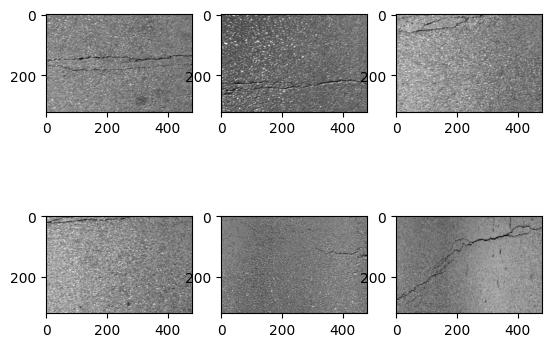

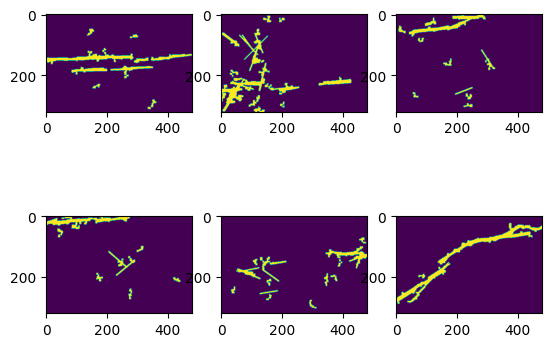

260
65
260
65


In [ ]:
# C3
# Visualizar y acomodar los datos

# Visualizar los datos
fig = plt.figure()
for i in range (0,6):
  a = fig.add_subplot(2,3,i+1)
  plt.imshow(image_list[i])
plt.show()

fig1 = plt.figure()
for j in range (0,6):
  b = fig1.add_subplot(2,3,j+1)
  plt.imshow(label_list[j][:,:,0])
plt.show()


# Separar los datos en conjunto de entrenamiento y prueba

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.20, random_state=42)  # Se requiere el 75% para entrenamiento


print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

In [ ]:
# C4
# Creación de la red U-Net
from keras.regularizers import l1, l2
# Modelo: U-Net
input_size = (320,480,3)

def unet(input_size = (320,480,3)):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(s)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    #Se define la capa de salida de la red, que consiste en una convolución 2D con un kernel de tamaño 1x1 y activación sigmoidal.
    #La salida de esta capa es una imagen binaria que representa la máscara de segmentación.
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

     # Capas de convolución con regularización L1 y L2
     #La regularización L1 y L2 se utiliza para evitar el sobreajuste y penalizar los pesos grandes de las capas de convolución.
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(0.01))(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(conv6)

    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(0.01))(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(conv7)

    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(0.01))(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(conv8)

    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(0.01))(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(conv9)

    # Capa de salida
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    return Model(inputs=inputs, outputs=conv10)

model = unet(input_size)

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 320, 480, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 320, 480, 64  1792        ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
# C5
# Entrenar el modelo

log=model.fit(x=np.array(X_train)
          ,y=np.array(y_train)
          ,epochs=30      # Definir el numero de epocas para el entrenamiento
          ,batch_size=2
          ,validation_data=(np.array(X_test),np.array(y_test)))


Epoch 1/30
130/130 [==============================] - 56s 421ms/step - loss: 22.8248 - accuracy: 0.9242 - val_loss: 18.5997 - val_accuracy: 0.9349
Epoch 2/30
130/130 [==============================] - 55s 420ms/step - loss: 15.1266 - accuracy: 0.9306 - val_loss: 11.9432 - val_accuracy: 0.9349
Epoch 3/30
130/130 [==============================] - 55s 421ms/step - loss: 9.4479 - accuracy: 0.9306 - val_loss: 7.2118 - val_accuracy: 0.9349
Epoch 4/30
130/130 [==============================] - 55s 421ms/step - loss: 5.5367 - accuracy: 0.9306 - val_loss: 4.0743 - val_accuracy: 0.9349
Epoch 5/30
130/130 [==============================] - 55s 420ms/step - loss: 3.0468 - accuracy: 0.9306 - val_loss: 2.1821 - val_accuracy: 0.9349
Epoch 6/30
130/130 [==============================] - 55s 422ms/step - loss: 1.6320 - accuracy: 0.9306 - val_loss: 1.1969 - val_accuracy: 0.9349
Epoch 7/30
130/130 [==============================] - 56s 431ms/step - loss: 0.8290 - accuracy: 0.9306 - val_loss: 0.4505 - va

1/1 [==============================] - 0s 23ms/step
Tiempo de ejecucion:  0.14042925834655762


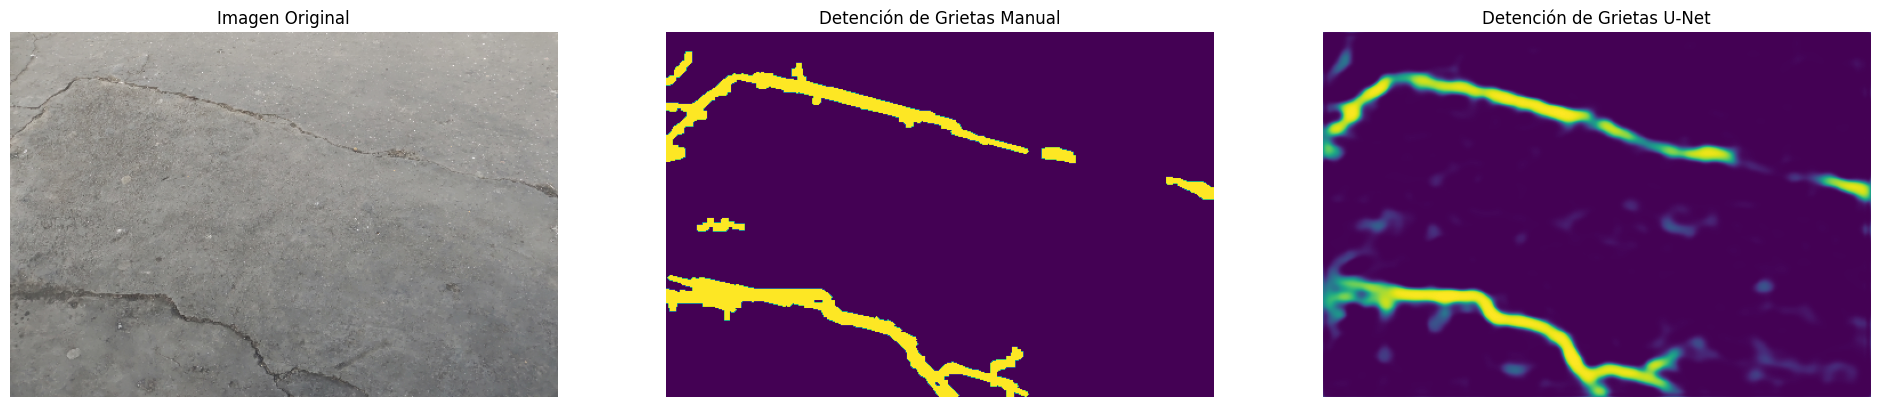

In [ ]:
# C6
# Probar el modelo con una sola imagen

t_l = y_test [5]
t1 = t_l[:,:,0]


inicio = time.time()
pred = model.predict(np.expand_dims(X_test[5],axis=0))
fin = time.time()
print ('Tiempo de ejecucion: ', fin-inicio)

plt.figure(figsize=(24, 6))

plt.subplot(131)
plt.imshow(X_test[5])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(t1)
plt.title('Detención de Grietas Manual')
plt.axis('off')

plt.subplot(133)
plt.imshow(pred[0,:,:,0])
plt.title('Detención de Grietas U-Net')
plt.axis('off')

plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

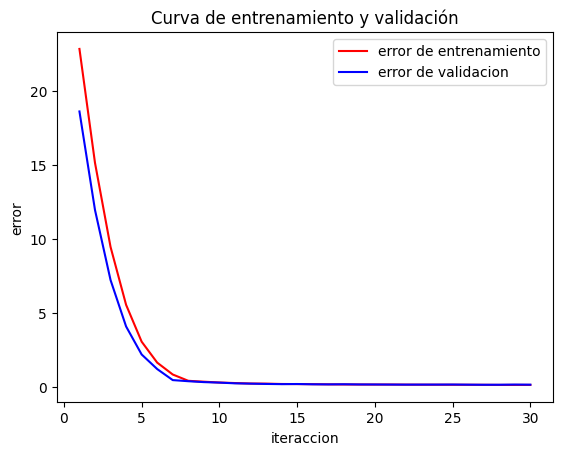

In [ ]:
error=log.history['loss']
val_error=log.history['val_loss']
epochs=range(1,len(error)+1)
plt.plot(epochs,error,color='red',label='error de entrenamiento')
plt.plot(epochs,val_error,color='blue',label='error de validacion')
plt.title('Curva de entrenamiento y validación')
plt.xlabel('iteraccion')
plt.ylabel('error')
plt.legend()
plt.show

3/3 [==============================] - 3s 1s/step
True Positives: 263829 ( 40.60000769437926 %)
False Positives: 49873 ( 0.5343053885319271 %)
True Negatives: 9284302 ( 99.46569461146807 %)
False Negatives: 385996 ( 59.39999230562074 %)
Precision: 0.8410179087159151
Recall: 0.4060000769437926


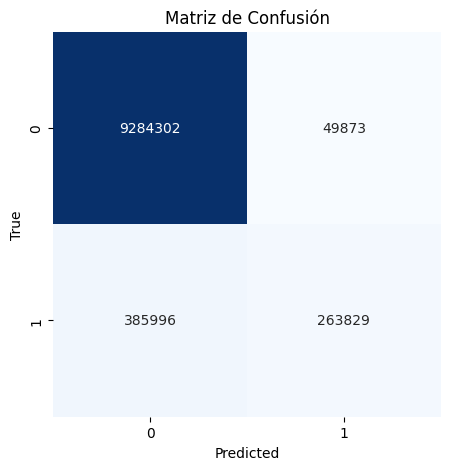

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(np.array(X_test))

# Redondear las predicciones a 0 o 1 (ya que es un problema de clasificación binaria)
y_pred_binary = np.round(y_pred).ravel()

# Convertir las etiquetas del conjunto de prueba a formato binario
y_test_binary = np.round(y_test).ravel()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Calcular los valores de interés
true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

# Calcular precision y recall
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

# Calcular porcentajes
total_samples = len(y_test_binary)
total_positives = true_positive + false_negative
total_negatives = true_negative + false_positive

percent_true_positive = (true_positive / total_positives) * 100
percent_false_positive = (false_positive / total_negatives) * 100
percent_true_negative = (true_negative / total_negatives) * 100
percent_false_negative = (false_negative / total_positives) * 100

# Mostrar los valores en la consola
print("True Positives:", true_positive, "(", percent_true_positive, "%)")
print("False Positives:", false_positive, "(", percent_false_positive, "%)")
print("True Negatives:", true_negative, "(", percent_true_negative, "%)")
print("False Negatives:", false_negative, "(", percent_false_negative, "%)")

print("Precision:", precision)
print("Recall:", recall)

# Mostrar la matriz de confusión como un gráfico de calor
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()
